<a href="https://colab.research.google.com/github/kiyomi0917/DoSA-PJ/blob/main/%E5%B0%8F%E9%87%8E%E3%81%8D%E3%82%88%E7%BE%8E%EF%BC%BF%E6%88%90%E6%9E%9C%E7%89%A9_RandomForest__Random_Search_%E5%93%81%E8%A9%9E%E3%81%AE%E3%81%BF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install Janome==0.3.7
!pip install --upgrade scikit-learn

In [9]:
import sklearn
print(sklearn.__version__)


1.3.0


In [10]:
vectorizer_methods = dir(vectorizer)
print(vectorizer_methods)


['__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__sklearn_clone__', '__str__', '__subclasshook__', '__weakref__', '_build_request_for_signature', '_char_ngrams', '_char_wb_ngrams', '_check_feature_names', '_check_n_features', '_check_params', '_check_stop_words_consistency', '_check_vocabulary', '_count_vocab', '_get_default_requests', '_get_metadata_request', '_get_param_names', '_get_tags', '_limit_features', '_more_tags', '_parameter_constraints', '_repr_html_', '_repr_html_inner', '_repr_mimebundle_', '_sort_features', '_stop_words_id', '_tfidf', '_validate_data', '_validate_ngram_range', '_validate_params', '_validate_vocabulary', '_warn_for_unused_params', '_white_spaces', '_word_ng

In [12]:
feature_names = vectorizer.get_feature_names_out()
print(feature_names)


['1' '10' '16' '17' '2' '3' '4' '709' '①' '②' '③②' 'うつ病' 'お前' 'お子さん' 'お茶'
 'お願い' 'か月' 'その後' 'ぶん殴り' 'やる気' 'アイデア' 'アドバイス' 'アナウンス' 'アホ' 'エマ' 'エリア'
 'オッケー' 'カ月' 'クライアント' 'グラフィック' 'グループ' 'コミュニケーション' 'コンビニエンスストア' 'コール'
 'サービス' 'スイッチ' 'スキル' 'スタッフ' 'ストッキング' 'ストレス' 'ストーカー' 'ストーキング' 'スピード' 'センター'
 'セールス' 'タイミング' 'タクシー' 'タスク' 'チェック' 'チャンス' 'チンピラ' 'テスト' 'テーマ' 'デザイン' 'データ'
 'トーク' 'ノート' 'ハラスメント' 'ハードウェア' 'バカ' 'パソコン' 'パチンコ' 'パフォーマンス' 'パワハラ' 'パワー'
 'パート' 'ヒアリング' 'ピアス' 'フォロー' 'フォント' 'プロジェクト' 'ヘルメット' 'ボケ' 'マニュアル' 'マネージャー'
 'ミス' 'ミーティング' 'メッセージ' 'メモ' 'メンタル' 'メーカー' 'メール' 'ユニット' 'リサイクル' 'ルール' 'レベル'
 'レポート' 'ヶ月' '一' '一つ' '一切' '一定' '一対一' '一時' '一流' '一般' '一貫' '一連' '上' '上司'
 '上申' '上記' '上限' '下' '下がる' '下げ' '不利益' '不可能' '不合格' '不妊' '不安定' '不平' '不当'
 '不愉快' '不服' '不正' '不法' '不満' '不良' '不要' '不調' '不足' '不適切' '与え' '両手' '両親' '並べ'
 '中' '中傷' '中学校' '中旬' '中略' '中華' '中途' '主任' '主張' '主治医' '乗せ' '乗務' '乗車' '了解'
 '予定' '争う' '事' '事件' '事務' '事務所' '事実' '事情' '事故' '事案' '事業' '事由' '事象' '二の次'
 '交流' '交通' '交際' '人' '人事' '人前' '人格' '人権' '人気' '人目' '人間' '

In [3]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from janome.tokenizer import Tokenizer
import re


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV

In [4]:
# Load the Excel file　読み込み
file_path = '/content/drive//MyDrive/DoSA/dataset_0619.xlsx'
xl = pd.ExcelFile(file_path)

# Load the desired sheet into a DataFrame　ファイルの指定シートを読み込み
df1 = xl.parse('訓練ﾃﾞｰﾀ')
df2 = xl.parse('ﾃｽﾄﾃﾞｰﾀ')

#ガイヨウトハラスメントハンテイヲ変数名に代入する（＝定義する）

train_data = df1["概要"]
train_labels =df1["ハラスメント判定"].astype(int)

test_data = df2["概要"]
test_labels = df2["ハラスメント判定"]

In [5]:
# テキストを分割する関数_テキストからすべての単語を抽出
t=Tokenizer()
def tokenize1(text):
    tokens = t.tokenize(text)
    word = []
    for token in tokens:
        word.append(token.surface)
    return word


# テキストから品詞(「名詞」「動詞」「形容詞」「形容動詞」)の単語を抽出し、全てひらがなまたは全て小文字英語の単語を除外
def tokenize2(text):
    tokens = t.tokenize(text)
    selected_words = []
    for token in tokens:
        # 「名詞」「動詞」「形容詞」「形容動詞」を取り出す
        if token.part_of_speech.split(',')[0] in ['名詞', '動詞', '形容詞', '形容動詞']:
            # 全てひらがなまたは全て小文字英語の単語は除外
            if not re.fullmatch("[あ-ん]*", token.surface) and not re.fullmatch("[a-z]*", token.surface):
                selected_words.append(token.surface)
    return selected_words


In [6]:
np.set_printoptions(threshold=np.inf)

In [7]:
#Tfid vecをvectorizerに代入する
vectorizer = TfidfVectorizer(tokenizer=tokenize2)#tokenizerは省略できない

#訓練データのトークン化・ベクトル化する
train_matrix = vectorizer.fit_transform(train_data)
train_matrix = train_matrix.toarray()#配列のかたをnumpy型にかえる
random.seed(42)

#元の配列を取ってランダムに並べ替える
rand_index = np.random.permutation(np.arange(len(train_matrix)))
print(rand_index)

#訓練データをランダムにシャッフルする処理
train_matrix = train_matrix[rand_index]
train_labels = train_labels[rand_index]

print(train_matrix)
print(train_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


ストリーミング出力は最後の 5000 行に切り捨てられました。
  0.         0.         0.         0.         0.20123051 0.12299137
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.


In [14]:
#単語リストを取得

# 単語リストを取得
feature_names = vectorizer.get_feature_names_out()
print(feature_names)


# print(vectorizer.get_feature_names())
words = vectorizer.get_feature_names_out()

for doc_no, vec in zip(range(len(train_data)), train_matrix):
    print('doc_no:', doc_no)

    for w_id, tfidf in sorted(enumerate(vec), key=lambda x: x[1], reverse=True):
        word = words[w_id]
        print('\t{0:s}: {1:f}'.format(word, tfidf))


ストリーミング出力は最後の 5000 行に切り捨てられました。
	下げ: 0.000000
	不利益: 0.000000
	不可能: 0.000000
	不合格: 0.000000
	不妊: 0.000000
	不安定: 0.000000
	不平: 0.000000
	不当: 0.000000
	不愉快: 0.000000
	不服: 0.000000
	不正: 0.000000
	不法: 0.000000
	不満: 0.000000
	不良: 0.000000
	不要: 0.000000
	不調: 0.000000
	不足: 0.000000
	不適切: 0.000000
	与え: 0.000000
	両手: 0.000000
	両親: 0.000000
	並べ: 0.000000
	中: 0.000000
	中傷: 0.000000
	中学校: 0.000000
	中旬: 0.000000
	中略: 0.000000
	中華: 0.000000
	中途: 0.000000
	主任: 0.000000
	主張: 0.000000
	主治医: 0.000000
	乗せ: 0.000000
	乗務: 0.000000
	乗車: 0.000000
	了解: 0.000000
	予定: 0.000000
	争う: 0.000000
	事: 0.000000
	事件: 0.000000
	事務: 0.000000
	事務所: 0.000000
	事実: 0.000000
	事情: 0.000000
	事故: 0.000000
	事案: 0.000000
	事業: 0.000000
	事由: 0.000000
	事象: 0.000000
	二の次: 0.000000
	交流: 0.000000
	交通: 0.000000
	交際: 0.000000
	人: 0.000000
	人前: 0.000000
	人格: 0.000000
	人権: 0.000000
	人気: 0.000000
	人目: 0.000000
	人間: 0.000000
	今: 0.000000
	今年度: 0.000000
	今後: 0.000000
	今時: 0.000000
	他: 0.000000
	付け: 0.000000
	代理: 0.000000
	代表: 0.000000
	以上: 0.000

In [15]:

#前のセルでトークン化した情報を表示
feature_names = vectorizer.get_feature_names_out()
for i in range(len(train_matrix)):
    tokens = [feature_names[j] for j in range(len(feature_names)) if train_matrix[i][j] > 0]
    print(f"トークン化結果 {i+1}: {tokens}")

#print(feature_names)
print(train_matrix.shape)

トークン化結果 1: ['1', 'スイッチ', 'チェック', 'バカ', 'ヘルメット', '主任', '作業', '側', '全体', '切ら', '受電', '回', '年', '後ろ', '怒鳴ら', '手', '指さし', '指揮', '接続', '死に', '点検', '確認', '箇所', '行う', '設備', '配線', '際']
トークン化結果 2: ['パワハラ', '不安定', '不平', '事情', '休職', '会議', '余儀なく', '年間', '感覚', '抱い', '持ちかけ', '推進', '方法', '日', '日頃', '最初', '毎月', '無視', '的', '目標', '相談', '社員', '精神', '考え', '自分', '言わ', '訴え', '課長', '進捗']
トークン化結果 3: ['その後', 'スピード', 'パワハラ', 'ミス', 'メーカー', '上', '上司', '何', '作業', '労働', '君', '問題', '多い', '多数', '就職', '度', '引き起こし', '強い', '形', '指導', '指摘', '損害', '改善', '数', '業務', '求める', '無くす', '状況', '疾患', '確認', '精神', '経理', '続い', '者', '職', '良い', '落とし', '行い', '解雇', '訴訟', '賠償', '起こし', '違法', '重ね', '際', '面談', '頻繁']
トークン化結果 4: ['一時', '上', '就か', '業務', '理由', '的', '簡易', '経営', '能力', '見合わ']
トークン化結果 5: ['促す', '向上', '悪い', '成績', '振るわ', '相応', '社員', '評価']
トークン化結果 6: ['上', '上司', '不利益', '人事', '依頼', '取扱い', '左遷', '建物', '損害', '明け渡し', '知人', '立ち退か', '説得', '請求', '賃借り', '賠償', '部下']
トークン化結果 7: ['与え', '仕事', '労働', '嫌がらせ', '気にいら', '者']
トークン化結果 8: ['パワハラ', '上司', '不満'

In [16]:
#ｲﾝｽﾀﾝｽ化=RFモデルをこうちく（定義する）
model = RandomForestClassifier()

#RFにベクトル化した情報を入れて学習させる、モデル内で持っている数値=パラメーターを調整する
model.fit(train_matrix, train_labels)

#テストデータをトークン化/ベクトル化
test_matrix = vectorizer.transform(test_data)

#test_matrix`に対する予測結果が`test_predictions`として格納される`test_matrix`は入力データ（特徴量）の行列であり、`test_predictions`は予測結果（目的変数）を格納するための変数
#テストデータの予測←ここのコードはmodel probaに変更したほうがいいかも？
#このデータに0/1が入っている
test_predictions = model.predict(test_matrix)



#予測結果を数値化＆可視化する
#113のうち、どれだけ正しく該非判定ができたかということ
test_accuracy = accuracy_score(test_labels, test_predictions)
print("ﾃｽﾄﾃﾞｰﾀの正解率:", test_accuracy)

#モデルが正と予測したもの(本来は非該当の事例も含まれている）のうち、正が実際にいくつあったか
precision = precision_score(test_labels, test_predictions)
print("ﾃｽﾄﾃﾞｰﾀの適合率:", precision)

#実際にハラスメント（実際の件数）に該当する事例をどれだけ正しく判定できているか
recall = recall_score(test_labels, test_predictions)
print("ﾃｽﾄﾃﾞｰﾀの再現率:", recall)

f1 = f1_score(test_labels, test_predictions)
print("ﾃｽﾄﾃﾞｰﾀのF1score:", f1)

#テストデータの予測結果のテキスのデータ、予測結果、予測結果のラベル
result = {}
for text, pred, correct in zip(test_data, test_predictions, test_labels):
  if result.get(f"{correct}-{pred}", None)==None:
     result[f"{correct}-{pred}"] = [text]
  else:
     result[f"{correct}-{pred}"].append(text)

#key=1,0ヤ0,0などを表す
for key in result:
  print(key)
  for text in result[key]:
    print(text)
  print()

ﾃｽﾄﾃﾞｰﾀの正解率: 0.6428571428571429
ﾃｽﾄﾃﾞｰﾀの適合率: 0.625
ﾃｽﾄﾃﾞｰﾀの再現率: 0.7142857142857143
ﾃｽﾄﾃﾞｰﾀのF1score: 0.6666666666666666
0-0
工事現場で建設機械の使い方を間違えていた作業員に対してリーダーが大声で注意した。
前の会議が長引き、次の会議に参加するためにオフィスの廊下を走っていたら、同僚にぶつかって相手がころんでしまった。
採用された新入社員は、業務を行ううえで多くのミスがあったため、上司は面談し「ミスが非常に多い」「仕事が遅いのは問題ないから、ミスがないようチェックしてから提出ほしい」と何度も指導した。その後もこの社員はミスがが多く、上司は何度も個別面談を設定したが改善されなかった。
会議で上司が部下に指導をしてもその部下が黙ったままで返事をしないため、上司が厳しい口調で「返事をしなさい！」と注意した。

0-1
会社の業績が低迷してきたため、部下に簡易な仕事を与えた。
この部下は将来有望と感じたため、ストレッチする意味でこれまで部下が経験したことのない難易度の高い業務の遂行を任せた。
勤務中に大地震が発生し、天井の一部が崩れ落ちてきたため、その下敷きになりそうな同僚を思いっきり突き飛ばした。

1-1
消防士長は昨年４～１１月、訓練中に複数の後輩職員の頭や肩をたたいたほか、「朝まで寝ないで訓練しろ」と言うなどして精神的苦痛を与えた。
事務所内で上司が腰や胸などを度々触るので、また触られるかもしれないと思うと仕事が手に付かず就業意欲が低下している。
部下が上司に妊娠を報告したところ、「次回の契約更新はないと思え」と言われた。
同僚から「こんな忙しい時期に妊娠するなんて信じられない」と繰り返し言われ、精神的に落ち込み業務に支障が出ている。
高等学校教が女子教諭に対してなされた、授業・担任等の仕事外し、職員室内での隔離、別の部屋への隔離、自宅研修等の命令した。

1-0
男性社員が育児休暇を申請したところ、「育休は女がとるものだ」と言われた。
「バカ野郎」と相手を侮辱する



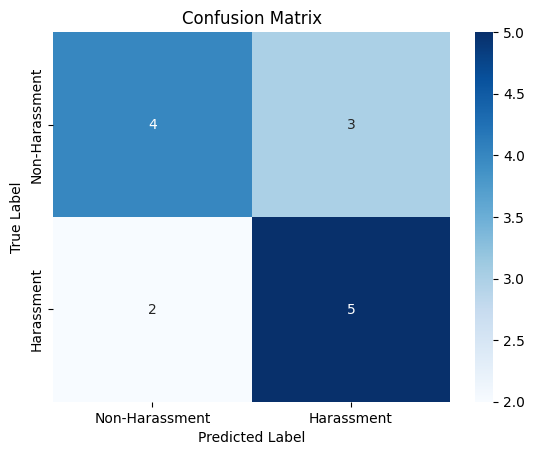

In [17]:
from sklearn.metrics import confusion_matrix

# 混同行列を作成
cm = confusion_matrix(test_labels, test_predictions)

# クラスのラベルを指定
class_labels = ['Non-Harassment', 'Harassment']

# 混合行列を可視化
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

# グラフの設定
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# グラフを表示
plt.show()

In [18]:
from sklearn.model_selection import train_test_split
from random import randint
import scipy

# データセットに合わせて train_X, train_y, test_X, test_y の値を定義する
train_X = train_matrix
train_y = train_labels
test_X = test_matrix
test_y = test_labels

# ハイパーパラメーターの値の候補を設定
model_param_set_random = {
    RandomForestClassifier(): {
        "n_estimators": scipy.stats.randint(1,300), # ランダムに1-299の範囲の整数を取り出す
        "max_depth": scipy.stats.randint(1,40),
        "min_samples_split": scipy.stats.randint(2,10), # 注意: min_samples_splitは最小でも2でないといけない        "random_state": [42]
    }
}

max_recall = 0
best_params_accuracy = None

#訓練データの一部をvalidationデータにする　書いていない場合は自動的に検証データは25%が適用される
train_X_temp, valid_X, train_y_temp, valid_y = train_test_split(train_X, train_y, random_state=42)

for model, param in model_param_set_random.items():

# Random Searchを使用してハイパーパラメーターの探索を行う。RandomizedSearchCVクラスを使用し、
# 指定したハイパーパラメーターの候補の中からランダムに組み合わせを選び、最適なパラメーターを探索します。
# その後、モデルの予測結果の正解率、適合率、再現率を計算し、最適なパラメーターと評価指標の値を更新します。

# Random Searchで最適なパラメーターを探索（recall）
    clf_recall = RandomizedSearchCV(model, param, scoring='recall')
    clf_recall.fit(train_X_temp, train_y_temp)
    pred_y = clf_recall.predict(valid_X)
    recall = recall_score(valid_y, pred_y)

    if recall > max_recall:
        max_recall = recall
        best_params_recall = clf_recall.best_params_

# 最適なパラメーターでモデルを再構築
best_model_recall = RandomForestClassifier(**best_params_recall)
best_model_recall.fit(train_X, train_y)

# テストデータを予測
pred_y = best_model_recall.predict(test_X)

# テストデータの正解率を計算して表示
accuracy = accuracy_score(test_y, pred_y)
print("テストデータの正解率:", accuracy)

# テストデータの適合率を計算して表示
precision = precision_score(test_y, pred_y)
print("テストデータの適合率:", precision)

# テストデータの再現率を計算して表示
recall = recall_score(test_y, pred_y)
print("テストデータの再現率:", recall)

# テストデータのF1スコアを計算して表示
f1 = f1_score(test_y, pred_y)
print("テストデータのF1スコア:", f1)

#テストデータの予測結果のテキスのデータ、予測結果、予測結果のラベル
result = {}
for text, pred, correct in zip(test_data, pred_y, test_labels):
  if result.get(f"{correct}-{pred}", None)==None:
     result[f"{correct}-{pred}"] = [text]
  else:
     result[f"{correct}-{pred}"].append(text)

#key=1,0ヤ0,0などを表す
for key in result:
  print(key)
  for text in result[key]:
    print(text)
  print()

テストデータの正解率: 0.7142857142857143
テストデータの適合率: 0.6666666666666666
テストデータの再現率: 0.8571428571428571
テストデータのF1スコア: 0.75
0-0
工事現場で建設機械の使い方を間違えていた作業員に対してリーダーが大声で注意した。
前の会議が長引き、次の会議に参加するためにオフィスの廊下を走っていたら、同僚にぶつかって相手がころんでしまった。
採用された新入社員は、業務を行ううえで多くのミスがあったため、上司は面談し「ミスが非常に多い」「仕事が遅いのは問題ないから、ミスがないようチェックしてから提出ほしい」と何度も指導した。その後もこの社員はミスがが多く、上司は何度も個別面談を設定したが改善されなかった。
会議で上司が部下に指導をしてもその部下が黙ったままで返事をしないため、上司が厳しい口調で「返事をしなさい！」と注意した。

0-1
会社の業績が低迷してきたため、部下に簡易な仕事を与えた。
この部下は将来有望と感じたため、ストレッチする意味でこれまで部下が経験したことのない難易度の高い業務の遂行を任せた。
勤務中に大地震が発生し、天井の一部が崩れ落ちてきたため、その下敷きになりそうな同僚を思いっきり突き飛ばした。

1-1
消防士長は昨年４～１１月、訓練中に複数の後輩職員の頭や肩をたたいたほか、「朝まで寝ないで訓練しろ」と言うなどして精神的苦痛を与えた。
事務所内で上司が腰や胸などを度々触るので、また触られるかもしれないと思うと仕事が手に付かず就業意欲が低下している。
部下が上司に妊娠を報告したところ、「次回の契約更新はないと思え」と言われた。
高等学校教が女子教諭に対してなされた、授業・担任等の仕事外し、職員室内での隔離、別の部屋への隔離、自宅研修等の命令した。
男性社員が育児休暇を申請したところ、「育休は女がとるものだ」と言われた。
「バカ野郎」と相手を侮辱する

1-0
同僚から「こんな忙しい時期に妊娠するなんて信じられない」と繰り返し言われ、精神的に落ち込み業務に支障が出ている。



In [24]:
# 単語リストを取得
feature_names = vectorizer.get_feature_names_out()

for doc_no, vec in zip(range(len(train_data)), train_matrix):
    print('doc_no:', doc_no)

    sorted_words = sorted(enumerate(vec), key=lambda x: x[1], reverse=True)

    for w_id, tfidf in sorted_words:
        word = feature_names[w_id]
        if tfidf != 0.0:
            print('\t{0:s}: {1:f}'.format(word, tfidf))


doc_no: 0
	受電: 0.354266
	接続: 0.354266
	配線: 0.354266
	スイッチ: 0.177133
	ヘルメット: 0.177133
	切ら: 0.177133
	後ろ: 0.177133
	手: 0.177133
	指さし: 0.177133
	指揮: 0.177133
	死に: 0.177133
	点検: 0.177133
	箇所: 0.177133
	設備: 0.177133
	バカ: 0.162892
	主任: 0.162892
	側: 0.162892
	怒鳴ら: 0.162892
	1: 0.152787
	チェック: 0.152787
	全体: 0.152787
	回: 0.138545
	作業: 0.133131
	年: 0.133131
	行う: 0.128441
	際: 0.128441
	確認: 0.120603
doc_no: 1
	言わ: 0.299200
	課長: 0.283312
	持ちかけ: 0.219722
	推進: 0.219722
	不安定: 0.202056
	不平: 0.202056
	事情: 0.202056
	抱い: 0.202056
	日頃: 0.202056
	最初: 0.202056
	感覚: 0.189522
	社員: 0.182870
	余儀なく: 0.179800
	進捗: 0.179800
	毎月: 0.171856
	無視: 0.171856
	相談: 0.171856
	考え: 0.171856
	方法: 0.165140
	目標: 0.165140
	休職: 0.159322
	年間: 0.159322
	訴え: 0.159322
	日: 0.154190
	会議: 0.149600
	自分: 0.149600
	精神: 0.126481
	パワハラ: 0.104740
	的: 0.101734
doc_no: 2
	ミス: 0.456437
	指導: 0.208344
	面談: 0.197918
	上司: 0.158504
	スピード: 0.157368
	メーカー: 0.157368
	君: 0.157368
	形: 0.157368
	無くす: 0.157368
	良い: 0.157368
	落とし: 0.157368
	引き起こし: 0.144716
	指摘

In [25]:
# 単語リストを取得
feature_names = vectorizer.get_feature_names_out()

# TF-IDF値のリストを作成
tfidf_values = train_matrix[0]  # 例としてtrain_matrixの最初の文書のTF-IDF値を使用

# 単語と対応するTF-IDF値のペアを作成
word_tfidf_pairs = [(word, tfidf) for word, tfidf in zip(feature_names, tfidf_values)]

# TF-IDF値が高い順にソート
sorted_pairs = sorted(word_tfidf_pairs, key=lambda pair: pair[1], reverse=True)

# ソートされた単語とTF-IDF値を表示
for word, tfidf in sorted_pairs:
    if tfidf != 0.0:
        print('{0:s}: {1:f}'.format(word, tfidf))


受電: 0.354266
接続: 0.354266
配線: 0.354266
スイッチ: 0.177133
ヘルメット: 0.177133
切ら: 0.177133
後ろ: 0.177133
手: 0.177133
指さし: 0.177133
指揮: 0.177133
死に: 0.177133
点検: 0.177133
箇所: 0.177133
設備: 0.177133
バカ: 0.162892
主任: 0.162892
側: 0.162892
怒鳴ら: 0.162892
1: 0.152787
チェック: 0.152787
全体: 0.152787
回: 0.138545
作業: 0.133131
年: 0.133131
行う: 0.128441
際: 0.128441
確認: 0.120603


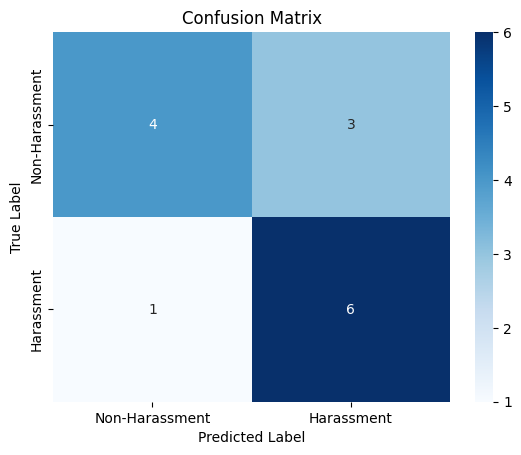

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# テストデータの混合行列を計算
cm = confusion_matrix(test_y, pred_y)

# クラスのラベルを指定
class_labels = ['Non-Harassment', 'Harassment']

# 混合行列を可視化
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

# グラフの設定
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# グラフを表示
plt.show()

In [20]:
import pickle

# 学習モデルを保存するパス
model_path = '/content/drive/MyDrive/model.pkl'

# 学習モデルを保存
with open(model_path, 'wb') as f:
    pickle.dump(best_model_recall, f)

# Saving model's performance
performance = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1
}

# Saving performance metrics to the drive
performance_path = '/content/drive/MyDrive/performance.pkl'
with open(performance_path, 'wb') as f:
    pickle.dump(performance, f)

print("学習モデルを保存しました。")

学習モデルを保存しました。
